In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
import os

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

dataset_dir = 'VAR'
output_dir = 'splitted_dataset'
classes = os.listdir(dataset_dir)

for folder in ['train', 'val', 'test']:
    for class_name in classes:
        os.makedirs(os.path.join(output_dir, folder, class_name), exist_ok=True)

for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)

    # 90% train, 10% sisa (test+val)
    train, test_val = train_test_split(images, test_size=0.10, random_state=42)
    # Bagi sisa jadi 50:50 → 5% val, 5% test
    val, test = train_test_split(test_val, test_size=0.5, random_state=42)

    for img in train:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, 'train', class_name))
    for img in val:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, 'val', class_name))
    for img in test:
        shutil.copy(os.path.join(class_path, img), os.path.join(output_dir, 'test', class_name))

print("✅ Dataset berhasil di-split ke folder 'splitted_dataset': 90% Train, 5% Validation, 5% Test!")

In [2]:
# **Path dataset**
base_dir = "splitted_dataset"
train_path = os.path.join(base_dir, "train")
val_path = os.path.join(base_dir, "val")
test_path = os.path.join(base_dir, "test")

In [3]:
# **Augmentasi Data**
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    shear_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.4, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

In [4]:
# **Load dataset dengan augmentasi**
batch_size = 32
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 1511 images belonging to 5 classes.
Found 81 images belonging to 5 classes.
Found 83 images belonging to 5 classes.


In [ ]:
# **Install timm library untuk MobileNetV4**
!pip install timm

In [5]:
import timm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image

c:\Users\USER PC\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# **Custom Dataset untuk PyTorch**
class ImageDataset(Dataset):
    def __init__(self, generator, transform=None):
        self.generator = generator
        self.transform = transform
        self.length = len(generator)
        
    def __len__(self):
        return self.length * self.generator.batch_size
    
    def __getitem__(self, idx):
        batch_idx = idx // self.generator.batch_size
        idx_in_batch = idx % self.generator.batch_size
        
        if batch_idx >= len(self.generator):
            batch_idx = batch_idx % len(self.generator)
            
        batch_x, batch_y = self.generator[batch_idx]
        
        if idx_in_batch >= len(batch_x):
            idx_in_batch = 0
            
        image = batch_x[idx_in_batch]
        label = np.argmax(batch_y[idx_in_batch])
        
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        
        return image, label

In [7]:
# **Create PyTorch DataLoaders**
train_dataset = ImageDataset(train_generator)
val_dataset = ImageDataset(val_generator)
test_dataset = ImageDataset(test_generator)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
# **Load MobileNetV4 Model**
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained MobileNetV4
base_model = timm.create_model('mobilenetv4_conv_small.e2400_r224_in1k', pretrained=True, num_classes=0)
base_model.eval()

# Freeze base model
for param in base_model.parameters():
    param.requires_grad = False

# Create new classifier on top
class MobileNetV4Classifier(nn.Module):
    def __init__(self, base_model, num_classes=5):
        super().__init__()
        self.base_model = base_model
        # Get output from a dummy input to determine feature size
        with torch.no_grad():
            dummy_input = torch.randn(2, 3, 224, 224)  # Use batch size 2
            features = base_model(dummy_input)
            num_features = features.shape[1]
        
        self.classifier = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        print(f"Number of features: {num_features}")
    
    def forward(self, x):
        x = self.base_model(x)
        x = self.classifier(x)
        return x

model = MobileNetV4Classifier(base_model).to(device)
print("MobileNetV4 model loaded successfully!")

Using device: cpu


c:\Users\USER PC\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:120: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\USER PC\.cache\huggingface\hub\models--timm--mobilenetv4_conv_small.e2400_r224_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Number of features: 1280
MobileNetV4 model loaded successfully!


In [12]:
# **Training Setup**
criterion = nn.CrossEntropyLoss()
# Only train the classifier, not the base model
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

num_epochs = 25
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

In [13]:
# **Training Loop**
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    train_loss /= len(train_loader)
    train_acc = train_correct / train_total
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

print("\n✅ Training completed!")

Epoch [1/25] - Train Loss: 1.1037, Train Acc: 0.5515 - Val Loss: 0.7866, Val Acc: 0.7578
Epoch [2/25] - Train Loss: 0.8028, Train Acc: 0.6694 - Val Loss: 1.2356, Val Acc: 0.5547
Epoch [2/25] - Train Loss: 0.8028, Train Acc: 0.6694 - Val Loss: 1.2356, Val Acc: 0.5547
Epoch [3/25] - Train Loss: 0.7104, Train Acc: 0.7100 - Val Loss: 1.0647, Val Acc: 0.5625
Epoch [3/25] - Train Loss: 0.7104, Train Acc: 0.7100 - Val Loss: 1.0647, Val Acc: 0.5625
Epoch [4/25] - Train Loss: 0.7026, Train Acc: 0.7067 - Val Loss: 1.2464, Val Acc: 0.5547
Epoch [4/25] - Train Loss: 0.7026, Train Acc: 0.7067 - Val Loss: 1.2464, Val Acc: 0.5547
Epoch [5/25] - Train Loss: 0.6615, Train Acc: 0.7209 - Val Loss: 1.7411, Val Acc: 0.5781
Epoch [5/25] - Train Loss: 0.6615, Train Acc: 0.7209 - Val Loss: 1.7411, Val Acc: 0.5781
Epoch [6/25] - Train Loss: 0.6126, Train Acc: 0.7511 - Val Loss: 1.2972, Val Acc: 0.5625
Epoch [6/25] - Train Loss: 0.6126, Train Acc: 0.7511 - Val Loss: 1.2972, Val Acc: 0.5625
Epoch [7/25] - Train 

In [14]:
# **Evaluasi Model pada Test Set**
model.eval()
test_correct = 0
test_total = 0
all_predictions = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc * 100:.2f}%")

Test Accuracy: 63.28%


In [15]:
# **Simpan Model**
torch.save(model.state_dict(), 'fould-classification-mobilenetv4.pth')
torch.save(model, 'fould-classification-mobilenetv4-full.pth')
print("✅ Model saved successfully!")

✅ Model saved successfully!


In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

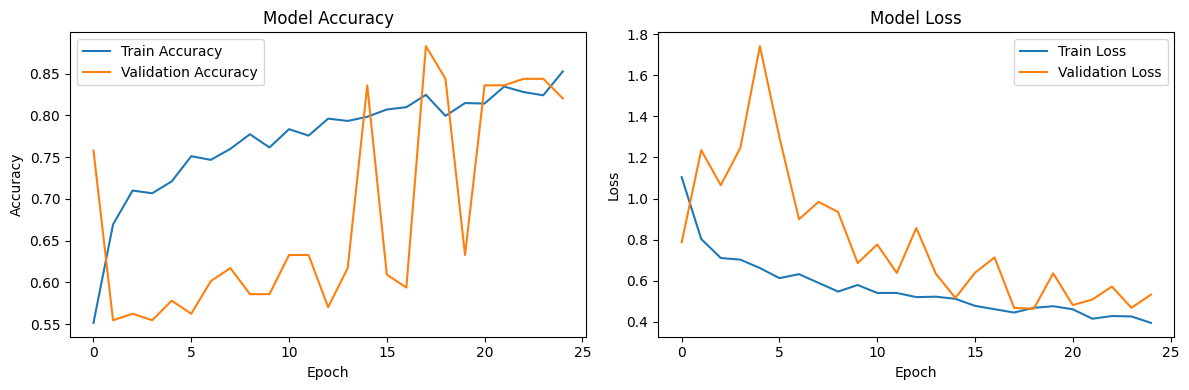

In [17]:
# **Plot Akurasi dan Loss**
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

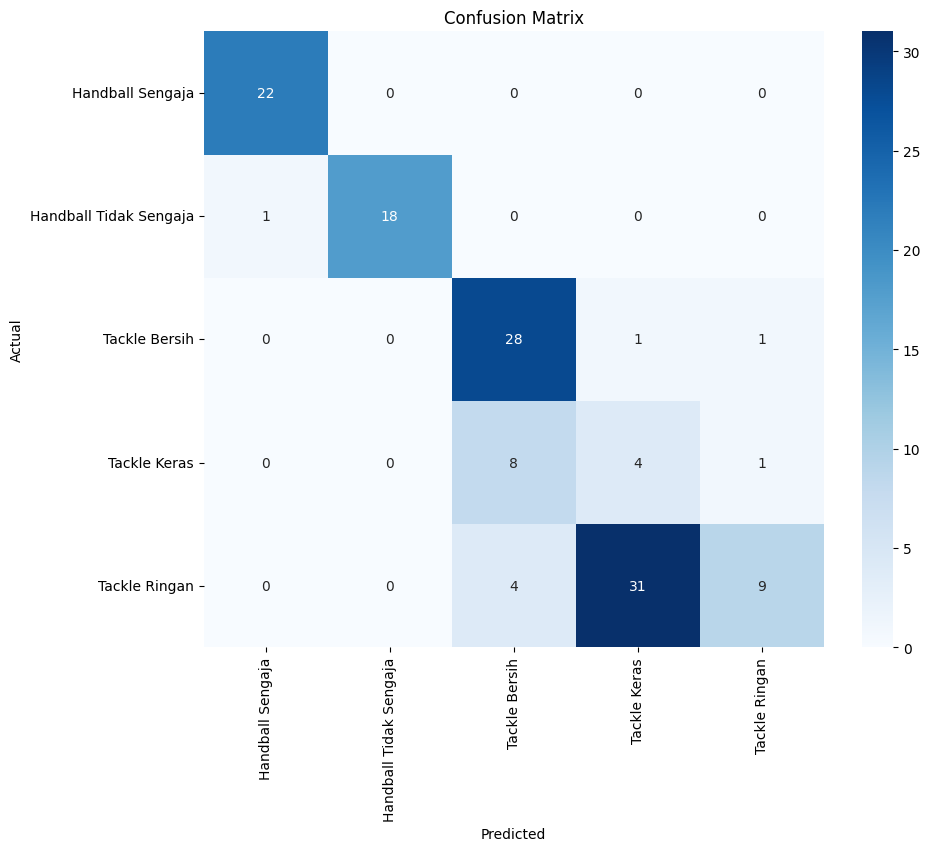


Classification Report:
                        precision    recall  f1-score   support

      Handball Sengaja       0.96      1.00      0.98        22
Handball Tidak Sengaja       1.00      0.95      0.97        19
         Tackle Bersih       0.70      0.93      0.80        30
          Tackle Keras       0.11      0.31      0.16        13
         Tackle Ringan       0.82      0.20      0.33        44

              accuracy                           0.63       128
             macro avg       0.72      0.68      0.65       128
          weighted avg       0.77      0.63      0.63       128



In [18]:
# **Confusion Matrix dan Classification Report**
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=class_labels))

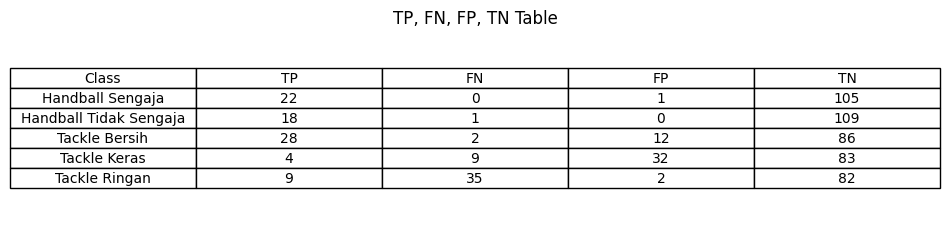


TP, FN, FP, TN for each class:
Handball Sengaja: TP=22, FN=0, FP=1, TN=105
Handball Tidak Sengaja: TP=18, FN=1, FP=0, TN=109
Tackle Bersih: TP=28, FN=2, FP=12, TN=86
Tackle Keras: TP=4, FN=9, FP=32, TN=83
Tackle Ringan: TP=9, FN=35, FP=2, TN=82


In [19]:
# **TP, FN, FP, TN Analysis**
num_classes = len(class_labels)
total_samples = np.sum(conf_matrix)

TP_list, FN_list, FP_list, TN_list = [], [], [], []

for i in range(num_classes):
    TP = conf_matrix[i, i]  
    FN = np.sum(conf_matrix[i, :]) - TP  
    FP = np.sum(conf_matrix[:, i]) - TP 
    TN = total_samples - (TP + FP + FN)  

    TP_list.append(TP)
    FN_list.append(FN)
    FP_list.append(FP)
    TN_list.append(TN)

fig, ax = plt.subplots(figsize=(10, num_classes * 0.5))
ax.axis('tight')
ax.axis('off')
table_data = [['Class', 'TP', 'FN', 'FP', 'TN']] + [[class_labels[i], TP_list[i], FN_list[i], FP_list[i], TN_list[i]] for i in range(num_classes)]
table = ax.table(cellText=table_data, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('TP, FN, FP, TN Table')
plt.show()

print("\nTP, FN, FP, TN for each class:")
for i in range(num_classes):
    print(f"{class_labels[i]}: TP={TP_list[i]}, FN={FN_list[i]}, FP={FP_list[i]}, TN={TN_list[i]}")

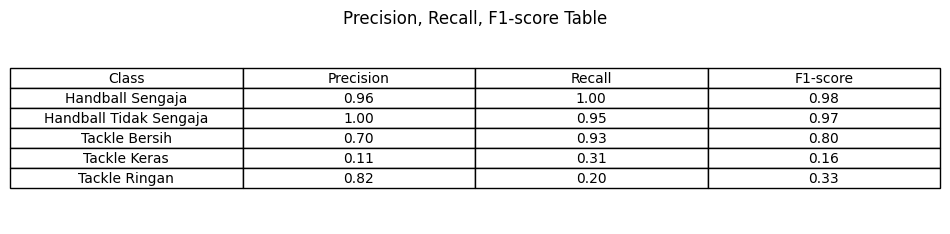

In [20]:
# **Precision, Recall, F1-score Table**
precision_list = [TP / (TP + FP) if (TP + FP) != 0 else 0 for TP, FP in zip(TP_list, FP_list)]
recall_list = [TP / (TP + FN) if (TP + FN) != 0 else 0 for TP, FN in zip(TP_list, FN_list)]
f1_score_list = [2 * (p * r) / (p + r) if (p + r) != 0 else 0 for p, r in zip(precision_list, recall_list)]

fig, ax = plt.subplots(figsize=(10, num_classes * 0.5))
ax.axis('tight')
ax.axis('off')
metrics_data = [['Class', 'Precision', 'Recall', 'F1-score']] + [[class_labels[i], f"{precision_list[i]:.2f}", f"{recall_list[i]:.2f}", f"{f1_score_list[i]:.2f}"] for i in range(num_classes)]
table = ax.table(cellText=metrics_data, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)
plt.title('Precision, Recall, F1-score Table')
plt.show()